In [72]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch
from torch import nn
import torch.utils.data as data
from tqdm import tqdm

In [5]:
#With heavy help from https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb

In [73]:
class FeedForward(nn.Module):
    #So bog basic it should tap for black mana
    #DT That one's for you
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 30)
        self.linear2 = nn.Linear(30,30)
        self.linear3 = nn.Linear(30,30)
        self.linear4 = nn.Linear(30,8)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = torch.clamp(x, -1e6, 1e6)
        return x

In [74]:
#Get the data into a nice form
with open('../data_folder/raw_data.json', 'r') as file:
    raw_data = json.load(file)

In [75]:
#Gonna want inputs, a list of 8d vectors; and outputs, a list of 8d vectors that come immediately after inputs
inputs = []
outputs = []
np.random.seed(522)
ts_indices = np.random.choice(len(raw_data), replace=False, size=len(raw_data)//4)
#Use a quarter of all time series generated 'cause there's a lot
for i in ts_indices:
    timeseries = raw_data[i]
    n_tsteps = timeseries['num_tsteps']
    #Also, use a quarter of all time steps
    tstep_indices = np.random.choice(n_tsteps-1, replace=False, size=n_tsteps//4)
    input_vecs = np.empty((len(tstep_indices), 8))
    output_vecs = np.empty((len(tstep_indices), 8))
    for j, k in enumerate(tstep_indices):
        input_vecs[j, 4:] = np.array([timeseries['theta1'][k], timeseries['theta2'][k], timeseries['theta1prime'][k], timeseries['theta2prime'][k]])
        output_vecs[j, 4:] = np.array([timeseries['theta1'][k+1], timeseries['theta2'][k+1], timeseries['theta1prime'][k+1], timeseries['theta2prime'][k+1]])
    input_vecs[:, :4] = np.array([timeseries['length1'], timeseries['length2'], timeseries['mass1'], timeseries['mass2']])
    output_vecs[:, :4] = np.array([timeseries['length1'], timeseries['length2'], timeseries['mass1'], timeseries['mass2']])
    for j in range(len(input_vecs)):
        inputs.append(list(input_vecs[j]))
        outputs.append(list(output_vecs[j]))
    
test_indices = np.random.choice(len(inputs), replace=False, size = len(inputs)//5)
remaining_indices = set(range(len(inputs))) - set(test_indices)
val_indices = np.random.choice(list(remaining_indices), replace=False, size=len(inputs)//5)
train_indices = list(set(range(len(inputs))) - set(test_indices) - set(val_indices))

assert set(train_indices).union(set(test_indices)).union(set(val_indices)) == set(range(len(inputs)))
assert len(set(train_indices).intersection(set(test_indices))) == 0
assert len(set(train_indices).intersection(set(val_indices))) == 0
assert len(set(test_indices).intersection(set(val_indices))) == 0

In [76]:
train_X = torch.tensor(np.array(inputs)[train_indices])
train_y = torch.tensor(np.array(outputs)[train_indices])
test_X = torch.tensor(np.array(inputs)[test_indices])
test_y = torch.tensor(np.array(outputs)[test_indices])
val_X = torch.tensor(np.array(inputs)[val_indices])
val_y = torch.tensor(np.array(outputs)[val_indices])

batch_size = 64

train_dataset = data.TensorDataset(train_X, train_y)
test_dataset = data.TensorDataset(test_X, test_y)
val_dataset = data.TensorDataset(val_X, val_y)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [77]:
with open('train_X.torch', 'wb') as file:
    torch.save(train_X, file)
with open('train_y.torch', 'wb') as file:
    torch.save(train_y, file)
with open('test_X.torch', 'wb') as file:
    torch.save(test_X, file)
with open('test_y.torch', 'wb') as file:
    torch.save(test_y, file)
with open('val_X.torch', 'wb') as file:
    torch.save(val_X, file)
with open('val_y.torch', 'wb') as file:
    torch.save(val_y, file)

In [78]:
g = 9.81
def derivatives(t, state):
    if torch.nan in state: pdb.set_trace()
    if torch.inf in state or -torch.inf in state: pdb.set_trace()
    L1, L2, m1, m2, theta1, z1, theta2, z2 = torch.split(state, 1, dim=1)
    delta = theta2 - theta1
    if torch.nan in delta: pdb.set_trace()
    if torch.inf in delta or -torch.inf in delta: pdb.set_trace()

    denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    denominator2 = (L2 / L1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * L2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    if torch.nan in dz1_dt: pdb.set_trace()
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )

    batched_zeros = np.zeros_like(dtheta1_dt)
    return np.column_stack([batched_zeros, batched_zeros, batched_zeros, batched_zeros, dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

In [79]:
def rk4_derivs(state, f, h):
    t = 0
    k1 = f(t, state)
    k2 = f(t + h*0.5, state + k1*h*0.5)
    k3 = f(t + h*0.5, state + k2*h*0.5)
    k4 = f(t + h, state + k3*h)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

class PINNLoss(nn.Module):
    def __init__(self, tstep, lamb=.5):
        super().__init__()
        self.tstep = tstep
        self.lamb = lamb
        self.data_crit = nn.MSELoss()
        self.physics_crit = nn.MSELoss()

    def forward(self, y_pred, y_true, input_data):
        data_loss = self.data_crit(y_pred, y_true)
        
        empirical_derivs = (y_pred - input_data) / self.tstep
        true_derivs = torch.tensor(rk4_derivs(input_data, derivatives, self.tstep))
        physics_loss = self.physics_crit(empirical_derivs, true_derivs)

        return self.lamb * data_loss + (1-self.lamb) * physics_loss

In [81]:
timestep = 10/1999
pinn = FeedForward()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
lamb = 0.5 #Test different values for this?
criterion = PINNLoss(timestep, lamb=lamb)
num_epochs = 120
val_every = 10
train_losses = []
val_losses = []
for i in tqdm(range(num_epochs)):
    train_losses_local = []
    for X_batch, y_batch in train_loader:
        # if torch.inf in X_batch or -torch.inf in y_batch:
        #     print('Found inf in data!')
        #     pdb.set_trace()
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        # empirical_derivs = (output_vector - input_data) / timestep
        # physics_loss = (derivs - derivatives(input_data))**2 #Divide by N elns?
        # data_loss = lamb*(true_output - output_vector)**2
        # loss = physics_loss + data_loss
        loss = criterion(y_pred, y_batch, X_batch)
        loss.backward()
        train_losses_local.append(loss.item())
        optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        pinn.eval()
        val_losses_local = []
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
            optimizer.zero_grad()
            y_pred = pinn(X_batch)
            loss = criterion(y_pred, y_batch, X_batch)
            val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps

100%|██████████| 120/120 [1:50:14<00:00, 55.12s/it]


In [82]:
with open('shuffled_120_epochs.torch', 'wb') as file:
    torch.save(pinn, file)

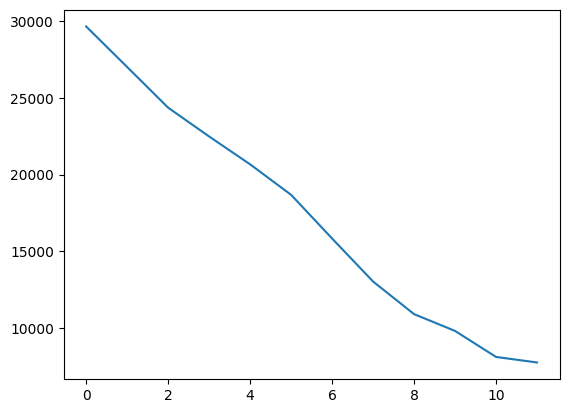

In [84]:
plt.plot(val_losses)

In [85]:
num_epochs = 20
val_every = 10
for i in tqdm(range(num_epochs)):
    train_losses_local = []
    for X_batch, y_batch in train_loader:
        # if torch.inf in X_batch or -torch.inf in y_batch:
        #     print('Found inf in data!')
        #     pdb.set_trace()
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        # empirical_derivs = (output_vector - input_data) / timestep
        # physics_loss = (derivs - derivatives(input_data))**2 #Divide by N elns?
        # data_loss = lamb*(true_output - output_vector)**2
        # loss = physics_loss + data_loss
        loss = criterion(y_pred, y_batch, X_batch)
        loss.backward()
        train_losses_local.append(loss.item())
        optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        pinn.eval()
        val_losses_local = []
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
            optimizer.zero_grad()
            y_pred = pinn(X_batch)
            loss = criterion(y_pred, y_batch, X_batch)
            val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps

100%|██████████| 20/20 [13:57<00:00, 41.86s/it]


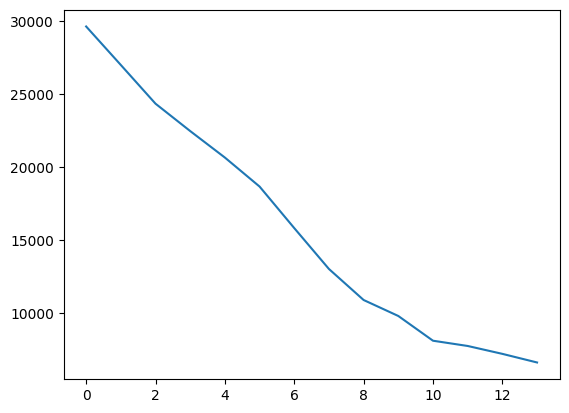

In [86]:
plt.plot(val_losses)

In [87]:
num_epochs = 40
val_every = 10
for i in tqdm(range(num_epochs)):
    train_losses_local = []
    for X_batch, y_batch in train_loader:
        # if torch.inf in X_batch or -torch.inf in y_batch:
        #     print('Found inf in data!')
        #     pdb.set_trace()
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        # empirical_derivs = (output_vector - input_data) / timestep
        # physics_loss = (derivs - derivatives(input_data))**2 #Divide by N elns?
        # data_loss = lamb*(true_output - output_vector)**2
        # loss = physics_loss + data_loss
        loss = criterion(y_pred, y_batch, X_batch)
        loss.backward()
        train_losses_local.append(loss.item())
        optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        pinn.eval()
        val_losses_local = []
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
            optimizer.zero_grad()
            y_pred = pinn(X_batch)
            loss = criterion(y_pred, y_batch, X_batch)
            val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps

 48%|████▊     | 19/40 [13:19<14:33, 41.59s/it]

In [70]:
with open('after_240_epochs.torch', 'wb') as file:
    torch.save(pinn, file)